In [1]:
# Custom connected neural network

# unpack and process data with the same code of Feed Forward Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

df = pd.read_pickle('new_spin_glass_dataset.pkl')

X = df[['J', 'T']].values
y = df[['energy', 'q_EA']].values

X_J = np.stack(df['J'].values)
X_T = df['T'].values.reshape(-1, 1)

X = np.hstack((X_J, X_T))

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X, y)

train_size = int(0.7 * len(dataset))  
val_size = int(0.2 * len(dataset))    
test_size = len(dataset) - train_size - val_size  

train_dataset, temp_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Cardinality training set: {len(train_dataset)}")
print(f"Cardinality validation set: {len(val_dataset)}")
print(f"Cardinality test set: {len(test_dataset)}")

Cardinality training set: 22960
Cardinality validation set: 6560
Cardinality test set: 3280


In [2]:
print(train_dataset[21])

(tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000,  1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000,  0.2000]), tensor([-43.2380,   0.8704]))


In [3]:
# definition of Custom Connected Neural Network

class CustomConnectedNN(nn.Module):
    def __init__(self, input_size):
        super(CustomConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(input_size, 36)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(36, 36)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(36, 2)  # Output layer

    def forward(self, x):
        x = self.tanh1(self.fc1(x))
        x = self.tanh2(self.fc2(x))
        x = self.tanh3(self.fc3(x))
        x = self.fc4(x)
        return x
    
# personal optimizer function to update parameters with a mask matrix
def manual_update(model, learning_rate, masks=None, num_layers = 0):
    i = 0
    with torch.no_grad():
        for param in model.parameters():
            if param.grad is not None:
                if i < (num_layers) : 
                    if masks[i] is not None:
                        if param.shape == masks[i].shape: # apply mask only for weights (not biases)
                            param.grad *= masks[i]
                            i += 1
                # update parameters (weights and biases)
                param -= learning_rate * param.grad
            
# function to inizialize to zero weights NOT allowed by the mask
def initialize_weights_with_mask(model, masks):
    with torch.no_grad():
        linear_layers = [layer for layer in model.children() if isinstance(layer, nn.Linear)]
        for layer, mask in zip(linear_layers, masks):
            weights = layer.weight.data
            weights *= mask

In [5]:
input_size = X.shape[1] # 61
model = CustomConnectedNN(input_size)

# loss function and optimizer 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
mask1 = torch.zeros((61,61))
mask1[:61, :61].fill_diagonal_(1)

mask2 = torch.zeros((61, 36))
for i in range(6):  
    for j in range(5):  
        start_col = i * 6 + j  
        if start_col + 1 < 36:  
            mask2[i * 5 + j, start_col:start_col+2] = 1

for i in range(30):  
    start_col = i   
    if start_col + 6 < 36:  
        mask2[30 + i, start_col:start_col+7:6] = 1

mask2[-1, :] = 1
mask2 = mask2.T


mask3 = torch.ones((36,36))

mask4 = torch.ones((2,36))

masks = [mask1, mask2, mask3, mask4]    

initialize_weights_with_mask(model, masks) 

learning_rate = 0.01

num_layers = sum(1 for layer in model.children() if isinstance(layer, nn.Linear)) # number of weights matrices to update

In [7]:
# computing the real number of trainable parameters

mask1_parameters = torch.sum(mask1 == 1).item()
print(mask1_parameters)
mask2_parameters = torch.sum(mask2 == 1).item()
print(mask2_parameters) #60*2 + 36
mask3_parameters = torch.sum(mask3 == 1).item()
print(mask3_parameters) # 36**2
mask4_parameters = torch.sum(mask4 == 1).item()
print(mask4_parameters) # 36*2
bias = 61 + 36 + 36 + 2
print(bias)

tot_parameters = mask1_parameters + mask2_parameters + mask3_parameters + mask4_parameters + bias
print(tot_parameters)

61
156
1296
72
135
1720


In [8]:
# check if all the parameters are correctly initialized
print("first layer weights (fc1):", model.fc1.weight.data)
print("first layer bias (fc1):", model.fc1.bias.data)
print("second layer weights (fc2):", model.fc2.weight.data)
print("second layer bias (fc2):", model.fc2.bias.data)
print("third layer weights (fc1):", model.fc3.weight.data)
print("third layer bias (fc1):", model.fc3.bias.data)
print("fourth layer weigths (fc2):", model.fc4.weight.data)
print("fourth layer bias (fc2):", model.fc4.bias.data)

first layer weights (fc1): tensor([[ 0.0104,  0.0000,  0.0000,  ...,  0.0000, -0.0000, -0.0000],
        [-0.0000, -0.1205, -0.0000,  ...,  0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0345,  ..., -0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000,  0.0000, -0.0000,  ...,  0.0089, -0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0054, -0.0000],
        [ 0.0000,  0.0000, -0.0000,  ..., -0.0000, -0.0000,  0.1149]])
first layer bias (fc1): tensor([ 0.0313, -0.0065, -0.0525,  0.1152, -0.0449, -0.0380, -0.1065, -0.0229,
         0.0058, -0.0672,  0.0053,  0.1274, -0.0071,  0.0056,  0.0056,  0.0410,
        -0.1254, -0.0748, -0.0096, -0.0588, -0.1023, -0.0638, -0.0477,  0.0208,
         0.0580, -0.0577, -0.0198, -0.0378,  0.0398, -0.0400, -0.1216,  0.1124,
        -0.1208,  0.0810, -0.0163, -0.0603,  0.1187, -0.0410, -0.0949, -0.1181,
        -0.1158,  0.1171,  0.0900, -0.0565,  0.0709,  0.0495,  0.0667, -0.0359,
        -0.0014, -0.0537,  0.0360, 

In [9]:
# training step

num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # manually update weights with masks
        manual_update(model, learning_rate, masks, num_layers)
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #print("first layer weights (fc1):", model.fc1.weight.data)
    #print("first layer bias (fc1):", model.fc1.bias.data)
    #print("second layer weights (fc2):", model.fc2.weight.data)
    #print("second layer bias (fc2):", model.fc2.bias.data)
    #print("third layer weights (fc1):", model.fc3.weight.data)
    #print("third layer bias (fc1):", model.fc3.bias.data)
    #print("fourth layer weights (fc2):", model.fc4.weight.data)
    #print("fourth layer bias (fc2):", model.fc4.bias.data)

Epoch [1/30], Train Loss: 66.3593, Val Loss: 26.6011
Epoch [2/30], Train Loss: 27.2373, Val Loss: 29.9490
Epoch [3/30], Train Loss: 25.8044, Val Loss: 25.6091
Epoch [4/30], Train Loss: 21.9647, Val Loss: 15.9360
Epoch [5/30], Train Loss: 13.7478, Val Loss: 14.7490
Epoch [6/30], Train Loss: 10.4299, Val Loss: 8.4109
Epoch [7/30], Train Loss: 8.8579, Val Loss: 6.4262
Epoch [8/30], Train Loss: 6.8835, Val Loss: 10.8214
Epoch [9/30], Train Loss: 5.6406, Val Loss: 4.0769
Epoch [10/30], Train Loss: 4.7125, Val Loss: 3.6224
Epoch [11/30], Train Loss: 4.1345, Val Loss: 3.3666
Epoch [12/30], Train Loss: 3.7922, Val Loss: 2.8166
Epoch [13/30], Train Loss: 3.3223, Val Loss: 4.9075
Epoch [14/30], Train Loss: 2.9440, Val Loss: 2.8576
Epoch [15/30], Train Loss: 2.7481, Val Loss: 2.4727
Epoch [16/30], Train Loss: 2.6264, Val Loss: 6.0915
Epoch [17/30], Train Loss: 2.4590, Val Loss: 3.8392
Epoch [18/30], Train Loss: 2.2760, Val Loss: 1.7974
Epoch [19/30], Train Loss: 2.0988, Val Loss: 2.7372
Epoch [20

In [10]:
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_preds.append(outputs.numpy())
        test_targets.append(targets.numpy())

test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# computing RMSE
rmse_energy = np.sqrt(mean_squared_error(test_targets[:, 0], test_preds[:, 0]))
rmse_q_EA = np.sqrt(mean_squared_error(test_targets[:, 1], test_preds[:, 1]))

print(f"RMSE Energy: {rmse_energy:.4f}")
print(f"RMSE q_EA: {rmse_q_EA:.4f}")

RMSE Energy: 1.6834
RMSE q_EA: 0.1532


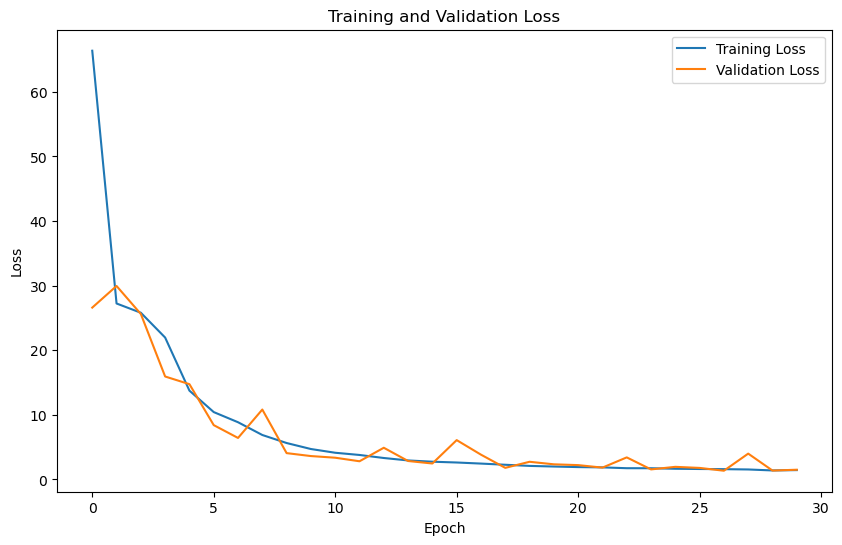

In [11]:
# plot the loss evolution
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

[[-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]]


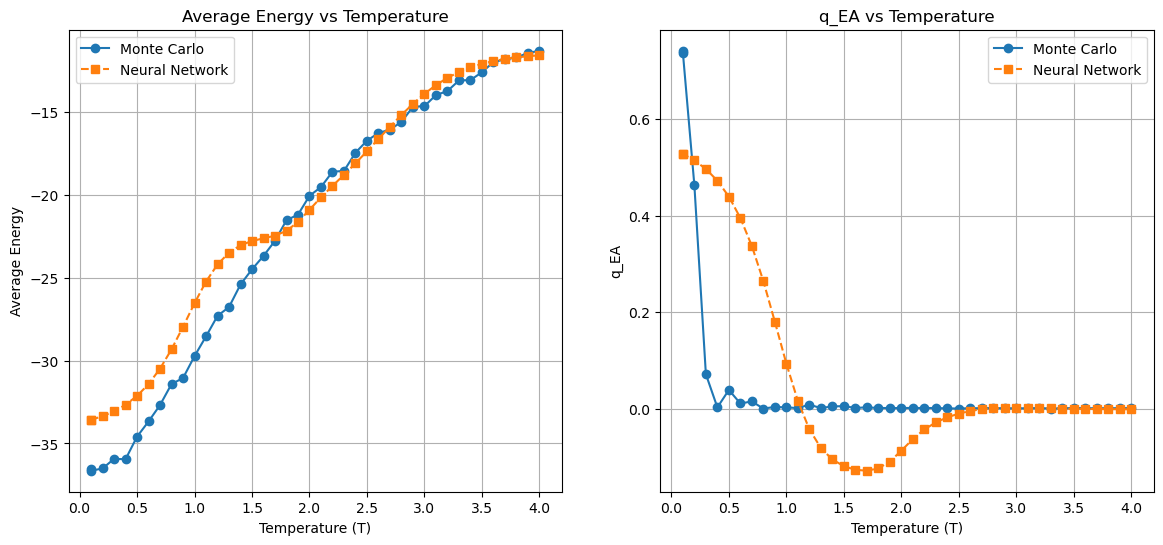

In [13]:
# evaluating the prediction capability with the same code of the Feed Forward Neural Network
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib


def create_initial_config(N=None):
    states = [-1., 1.]
    config = np.random.choice(states, (N, N))
    return config


def metropolis_single_update(config=None, T=None, J=None):
    N, M = config.shape
    assert N == M, "Wrong configuration shape"
    i = np.random.randint(N)
    j = np.random.randint(M)
    s = config[i, j]
    DeltaE = 2 * s * (J[i, j, 0] * config[i, (j - 1) % N] + J[i, j, 1] * config[i, (j + 1) % N] + J[i, j, 2] * config[
        (i + 1) % N, j] + J[i, j, 3] * config[(i - 1) % N, j])
    effDeltaE = 0
    if DeltaE < 0:
        s *= -1
        effDeltaE = DeltaE
    else:
        if np.random.random() < np.exp(-DeltaE / T):
            s *= -1
            effDeltaE = DeltaE
    config[i, j] = s
    return effDeltaE


def create_vector(N, p):
    dim = (N - 1) * N * 2
    vector = np.ones(dim, dtype=int)
    negative_indices = np.random.choice(dim, p, replace=False)
    vector[negative_indices] = -1
    return vector


def create_spin_glass_dataset(N, v):
    J = np.zeros((N, N, 4), dtype=int)
    count = 0
    for i in range(N):
        for j in range(N):
            if j == 0:
                J[i, j, 0] = 0
            else:
                J[i, j, 0] = J[i, j - 1, 1]
            if j == N - 1:
                J[i, j, 1] = 0
            else:
                J[i, j, 1] = v[count]
                count = count + 1
            if i == 0:
                J[i, j, 2] = 0
            else:
                J[i, j, 2] = J[i - 1, j, 3]
            if i == N - 1:
                J[i, j, 3] = 0
            else:
                J[i, j, 3] = v[count]
                count = count + 1
    return J


def compute_q_EA(config_history):
    N = config_history.shape[1]
    avg_spins = np.mean(config_history, axis=0)
    q_EA = np.sum(avg_spins ** 2) / (N * N)
    return q_EA


def compute_total_energy(config, J):
    N, M = config.shape
    total_energy = 0
    for i in range(N):
        for j in range(M):
            s = config[i, j]
            total_energy -= s * (J[i, j, 0] * config[i, (j - 1) % N] +
                                 J[i, j, 1] * config[i, (j + 1) % N] +
                                 J[i, j, 2] * config[(i + 1) % N, j] +
                                 J[i, j, 3] * config[(i - 1) % N, j])
    return total_energy / 2  # To account for double-counting



N = 6
T_values = np.arange(4, 0, -0.1)
T_values = np.append(T_values, 0.1)
n_updates = 100000


p = random.choice(range(0, (N - 1) * N * 2 + 1))
v = create_vector(N, p)
J = create_spin_glass_dataset(N, v)


config = create_initial_config(N)

mc_energies = []
mc_q_EAs = []

for T in T_values:
    total_energy_sum = 0
    config_history = []
    total_measurements = 0

    for k in range(n_updates):
        DeltaE = metropolis_single_update(config, T=T, J=J)
        if k > 10000 and k % 100 == 0:
            config_history.append(config.copy())
            total_energy = compute_total_energy(config, J)
            total_energy_sum += total_energy
            total_measurements += 1

    average_energy = total_energy_sum / total_measurements
    config_history = np.array(config_history)
    q_EA = compute_q_EA(config_history)

    mc_energies.append(average_energy)
    mc_q_EAs.append(q_EA)


J_new = []


for i in range(N):
    for j in range(N - 1):
        J_new.append(J[i, j, 1])  


for i in range(N - 1):
    for j in range(N):
        J_new.append(J[i, j, 3])  

J_new = np.array(J_new)

print(J_new.reshape(-1, 1))
model.eval()


J_flattened = J_new.reshape(1, -1)
T_values_tensor = torch.tensor(T_values.reshape(-1, 1), dtype=torch.float32)
J_tensors = torch.tensor(J_flattened, dtype=torch.float32).repeat(len(T_values), 1)
X_test = torch.cat((J_tensors, T_values_tensor), dim=1)


with torch.no_grad():
    y_pred = model(X_test)
    

nn_energies = y_pred[:, 0]
nn_q_EAs = y_pred[:, 1]

plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(T_values, mc_energies, 'o-', label='Monte Carlo')
plt.plot(T_values, nn_energies, 's--', label='Neural Network')
plt.xlabel('Temperature (T)')
plt.ylabel('Average Energy')
plt.title('Average Energy vs Temperature')
plt.legend()
plt.grid(True)

# q_EA
plt.subplot(1, 2, 2)
plt.plot(T_values, mc_q_EAs, 'o-', label='Monte Carlo')
plt.plot(T_values, nn_q_EAs, 's--', label='Neural Network')
plt.xlabel('Temperature (T)')
plt.ylabel('q_EA')
plt.title('q_EA vs Temperature')
plt.legend()
plt.grid(True)

plt.show()